In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import scanpy as sc
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from dataclasses import dataclass
import seaborn as sns
import numpy as np

In [28]:
@dataclass
class DataLoaderResult:
    train_dataset: TensorDataset
    train_loader: DataLoader
    test_dataset: TensorDataset
    test_loader: DataLoader
    label_encoder: LabelEncoder
    X_train: torch.Tensor
    X_test: torch.Tensor
    y_train: torch.Tensor
    y_test: torch.Tensor
    label_encoder: LabelEncoder

def preprocess_adata_for_deeplearning(adata,
                                      highly_variable_genes=None,
                                      test_size=0.2,
                                      random_state=42,
                                      batch_size=64):
    """
    :param adata: AnnData object adata.X 应该是 scaled data
    :param highly_variable_genes: list of highly variable genes 
    :param test_size: float, default=0.2
    :param random_state: int, default=42
    :param batch_size: int, default=64
    """
    if not highly_variable_genes:
        highly_variable_genes = adata.var[adata.var['highly_variable']].index

    X = adata[:, highly_variable_genes].X
    y = adata.obs['cell_type'].values
    le = LabelEncoder()
    y = le.fit_transform(y)
    # le.transorm can 
    if hasattr(X, "toarray"):
        X_tensor = torch.tensor(X.toarray(), dtype=torch.float32)
    else:
        X_tensor = torch.tensor(X, dtype=torch.float32)

    y_tensor = torch.tensor(y, dtype=torch.long)
    print(X_tensor.shape, y_tensor.shape)
    # 将数据拆分成训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=test_size, random_state=random_state)

    # 定义数据加载器
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return DataLoaderResult(train_dataset=train_dataset,
                            train_loader=train_loader,
                            test_dataset=test_dataset,
                            test_loader=test_loader,
                            label_encoder=le,
                            X_train=X_train,
                            X_test=X_test,
                            y_train=y_train,
                            y_test=y_test)

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=2,dropout_prob=0.5):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(dropout_prob),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_prob),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_prob),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_prob),
            nn.Linear(128, hidden_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512,1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

def train_autoencoder(model, train_loader, num_epochs=30, learning_rate=0.001):
    model = model.to(device)
    writer = SummaryWriter(log_dir='./runs/experiment_autoencoder')
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
            inputs, _ = inputs.to(device), _.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # Log training loss and accuracy
        writer.add_scalar('Loss/train', running_loss/len(train_loader), epoch)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 设定用于绘制latent layer的函数
def plot_latent_space(model, train_loader, test_loader, label_encoder):
    model.eval()
    
    # 获取训练集和测试集的latent representations
    with torch.no_grad():
        train_latent_representations = []
        test_latent_representations = []
        train_labels = []
        test_labels = []

        # 获取训练集的latent representations
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device) 
            encoded = model.encoder(inputs)
            train_latent_representations.append(encoded)
            train_labels.append(targets)
        
        # 获取测试集的latent representations
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            encoded = model.encoder(inputs)
            test_latent_representations.append(encoded)
            test_labels.append(targets)
        
        # 将数据拼接起来
        train_latent_representations = torch.cat(train_latent_representations).cpu().numpy()
        test_latent_representations = torch.cat(test_latent_representations).cpu().numpy()
        train_labels = torch.cat(train_labels).cpu().numpy()
        test_labels = torch.cat(test_labels).cpu().numpy()
    
    # 将数字标签转换为原始细胞类型
    train_labels = label_encoder.inverse_transform(train_labels)
    test_labels = label_encoder.inverse_transform(test_labels)
    
    # 设置seaborn调色板
    sc.settings.set_figure_params(dpi=80, facecolor='white')  # 可选的设定，调整绘图风格
    palette = sc.pl.palettes.default_102  # 使用默认调色板
    
    # 创建一个字典来确保细胞类型和颜色的一一对应
    unique_labels = np.unique(train_labels)
    label_color_map = {label: palette[i] for i, label in enumerate(unique_labels)}

    # 绘制训练集的latent space
    plt.figure(figsize=(14, 10))

    # 第一行：训练集
    plt.subplot(2, 1, 1)
    sns.scatterplot(x=train_latent_representations[:, 0], y=train_latent_representations[:, 1], 
                    hue=train_labels, palette=label_color_map, alpha=0.7, legend='full')
    plt.title('Train Latent Space Representation')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    # 第二行：测试集
    plt.subplot(2, 1, 2)
    sns.scatterplot(x=test_latent_representations[:, 0], y=test_latent_representations[:, 1], 
                    hue=test_labels, palette=label_color_map, alpha=0.7, legend='full')
    plt.title('Test Latent Space Representation')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [5]:
adata = sc.read_h5ad("./data/subset_intestine.h5ad")
adata

AnnData object with n_obs × n_vars = 44084 × 33538
    obs: 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'sample_id', 'project_id', 'sample_type', 'tissue', 'anatomical_site', 'disease', 'platform', 'age_group', 'cell_sorting', 'treatment', 'subject_id', 'age', 'gender', 'rna_source', 'other_metadata'
    var: 'gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'hvg', 'log1p', 'project_id_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts', 'data'

In [29]:
data_result = preprocess_adata_for_deeplearning(adata)

torch.Size([44084, 2000]) torch.Size([44084])


In [30]:
model = Autoencoder(input_dim=data_result.X_train.shape[1])
train_autoencoder(model, data_result.train_loader, num_epochs=30, learning_rate=0.001)

Epoch 1/30: 100%|██████████| 552/552 [00:02<00:00, 197.01batch/s]


Epoch [1/30], Loss: 1.5573


Epoch 2/30: 100%|██████████| 552/552 [00:02<00:00, 224.33batch/s]


Epoch [2/30], Loss: 0.7675


Epoch 3/30: 100%|██████████| 552/552 [00:02<00:00, 223.86batch/s]


Epoch [3/30], Loss: 1.0328


Epoch 4/30: 100%|██████████| 552/552 [00:02<00:00, 223.12batch/s]


Epoch [4/30], Loss: 0.5344


Epoch 5/30: 100%|██████████| 552/552 [00:02<00:00, 224.48batch/s]


Epoch [5/30], Loss: 0.7192


Epoch 6/30: 100%|██████████| 552/552 [00:02<00:00, 220.34batch/s]


Epoch [6/30], Loss: 0.4076


Epoch 7/30: 100%|██████████| 552/552 [00:02<00:00, 224.43batch/s]


Epoch [7/30], Loss: 1.3854


Epoch 8/30: 100%|██████████| 552/552 [00:02<00:00, 226.21batch/s]


Epoch [8/30], Loss: 1.3854


Epoch 9/30: 100%|██████████| 552/552 [00:02<00:00, 223.97batch/s]


Epoch [9/30], Loss: 0.6486


Epoch 10/30: 100%|██████████| 552/552 [00:02<00:00, 224.41batch/s]


Epoch [10/30], Loss: 0.5266


Epoch 11/30: 100%|██████████| 552/552 [00:02<00:00, 220.69batch/s]


Epoch [11/30], Loss: 1.4935


Epoch 12/30: 100%|██████████| 552/552 [00:02<00:00, 225.09batch/s]


Epoch [12/30], Loss: 0.7448


Epoch 13/30: 100%|██████████| 552/552 [00:02<00:00, 218.71batch/s]


Epoch [13/30], Loss: 1.3239


Epoch 14/30: 100%|██████████| 552/552 [00:02<00:00, 222.13batch/s]


Epoch [14/30], Loss: 0.8222


Epoch 15/30: 100%|██████████| 552/552 [00:02<00:00, 219.67batch/s]


Epoch [15/30], Loss: 3.7950


Epoch 16/30: 100%|██████████| 552/552 [00:02<00:00, 220.14batch/s]


Epoch [16/30], Loss: 1.5369


Epoch 17/30: 100%|██████████| 552/552 [00:02<00:00, 221.72batch/s]


Epoch [17/30], Loss: 0.8969


Epoch 18/30: 100%|██████████| 552/552 [00:02<00:00, 219.49batch/s]


Epoch [18/30], Loss: 1.5712


Epoch 19/30: 100%|██████████| 552/552 [00:02<00:00, 221.74batch/s]


Epoch [19/30], Loss: 1.0870


Epoch 20/30: 100%|██████████| 552/552 [00:02<00:00, 222.75batch/s]


Epoch [20/30], Loss: 0.6377


Epoch 21/30: 100%|██████████| 552/552 [00:02<00:00, 221.63batch/s]


Epoch [21/30], Loss: 0.8958


Epoch 22/30: 100%|██████████| 552/552 [00:02<00:00, 220.19batch/s]


Epoch [22/30], Loss: 1.3133


Epoch 23/30: 100%|██████████| 552/552 [00:02<00:00, 216.91batch/s]


Epoch [23/30], Loss: 0.6231


Epoch 24/30: 100%|██████████| 552/552 [00:02<00:00, 219.72batch/s]


Epoch [24/30], Loss: 3.0584


Epoch 25/30: 100%|██████████| 552/552 [00:02<00:00, 223.44batch/s]


Epoch [25/30], Loss: 0.9832


Epoch 26/30: 100%|██████████| 552/552 [00:02<00:00, 220.81batch/s]


Epoch [26/30], Loss: 0.6264


Epoch 27/30: 100%|██████████| 552/552 [00:02<00:00, 220.71batch/s]


Epoch [27/30], Loss: 0.6376


Epoch 28/30: 100%|██████████| 552/552 [00:02<00:00, 220.98batch/s]


Epoch [28/30], Loss: 1.0263


Epoch 29/30: 100%|██████████| 552/552 [00:02<00:00, 225.90batch/s]


Epoch [29/30], Loss: 0.7624


Epoch 30/30: 100%|██████████| 552/552 [00:02<00:00, 225.00batch/s]

Epoch [30/30], Loss: 0.7736


C:\Users\Administrator\AppData\Local\Temp\ipykernel_8088\1278976965.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


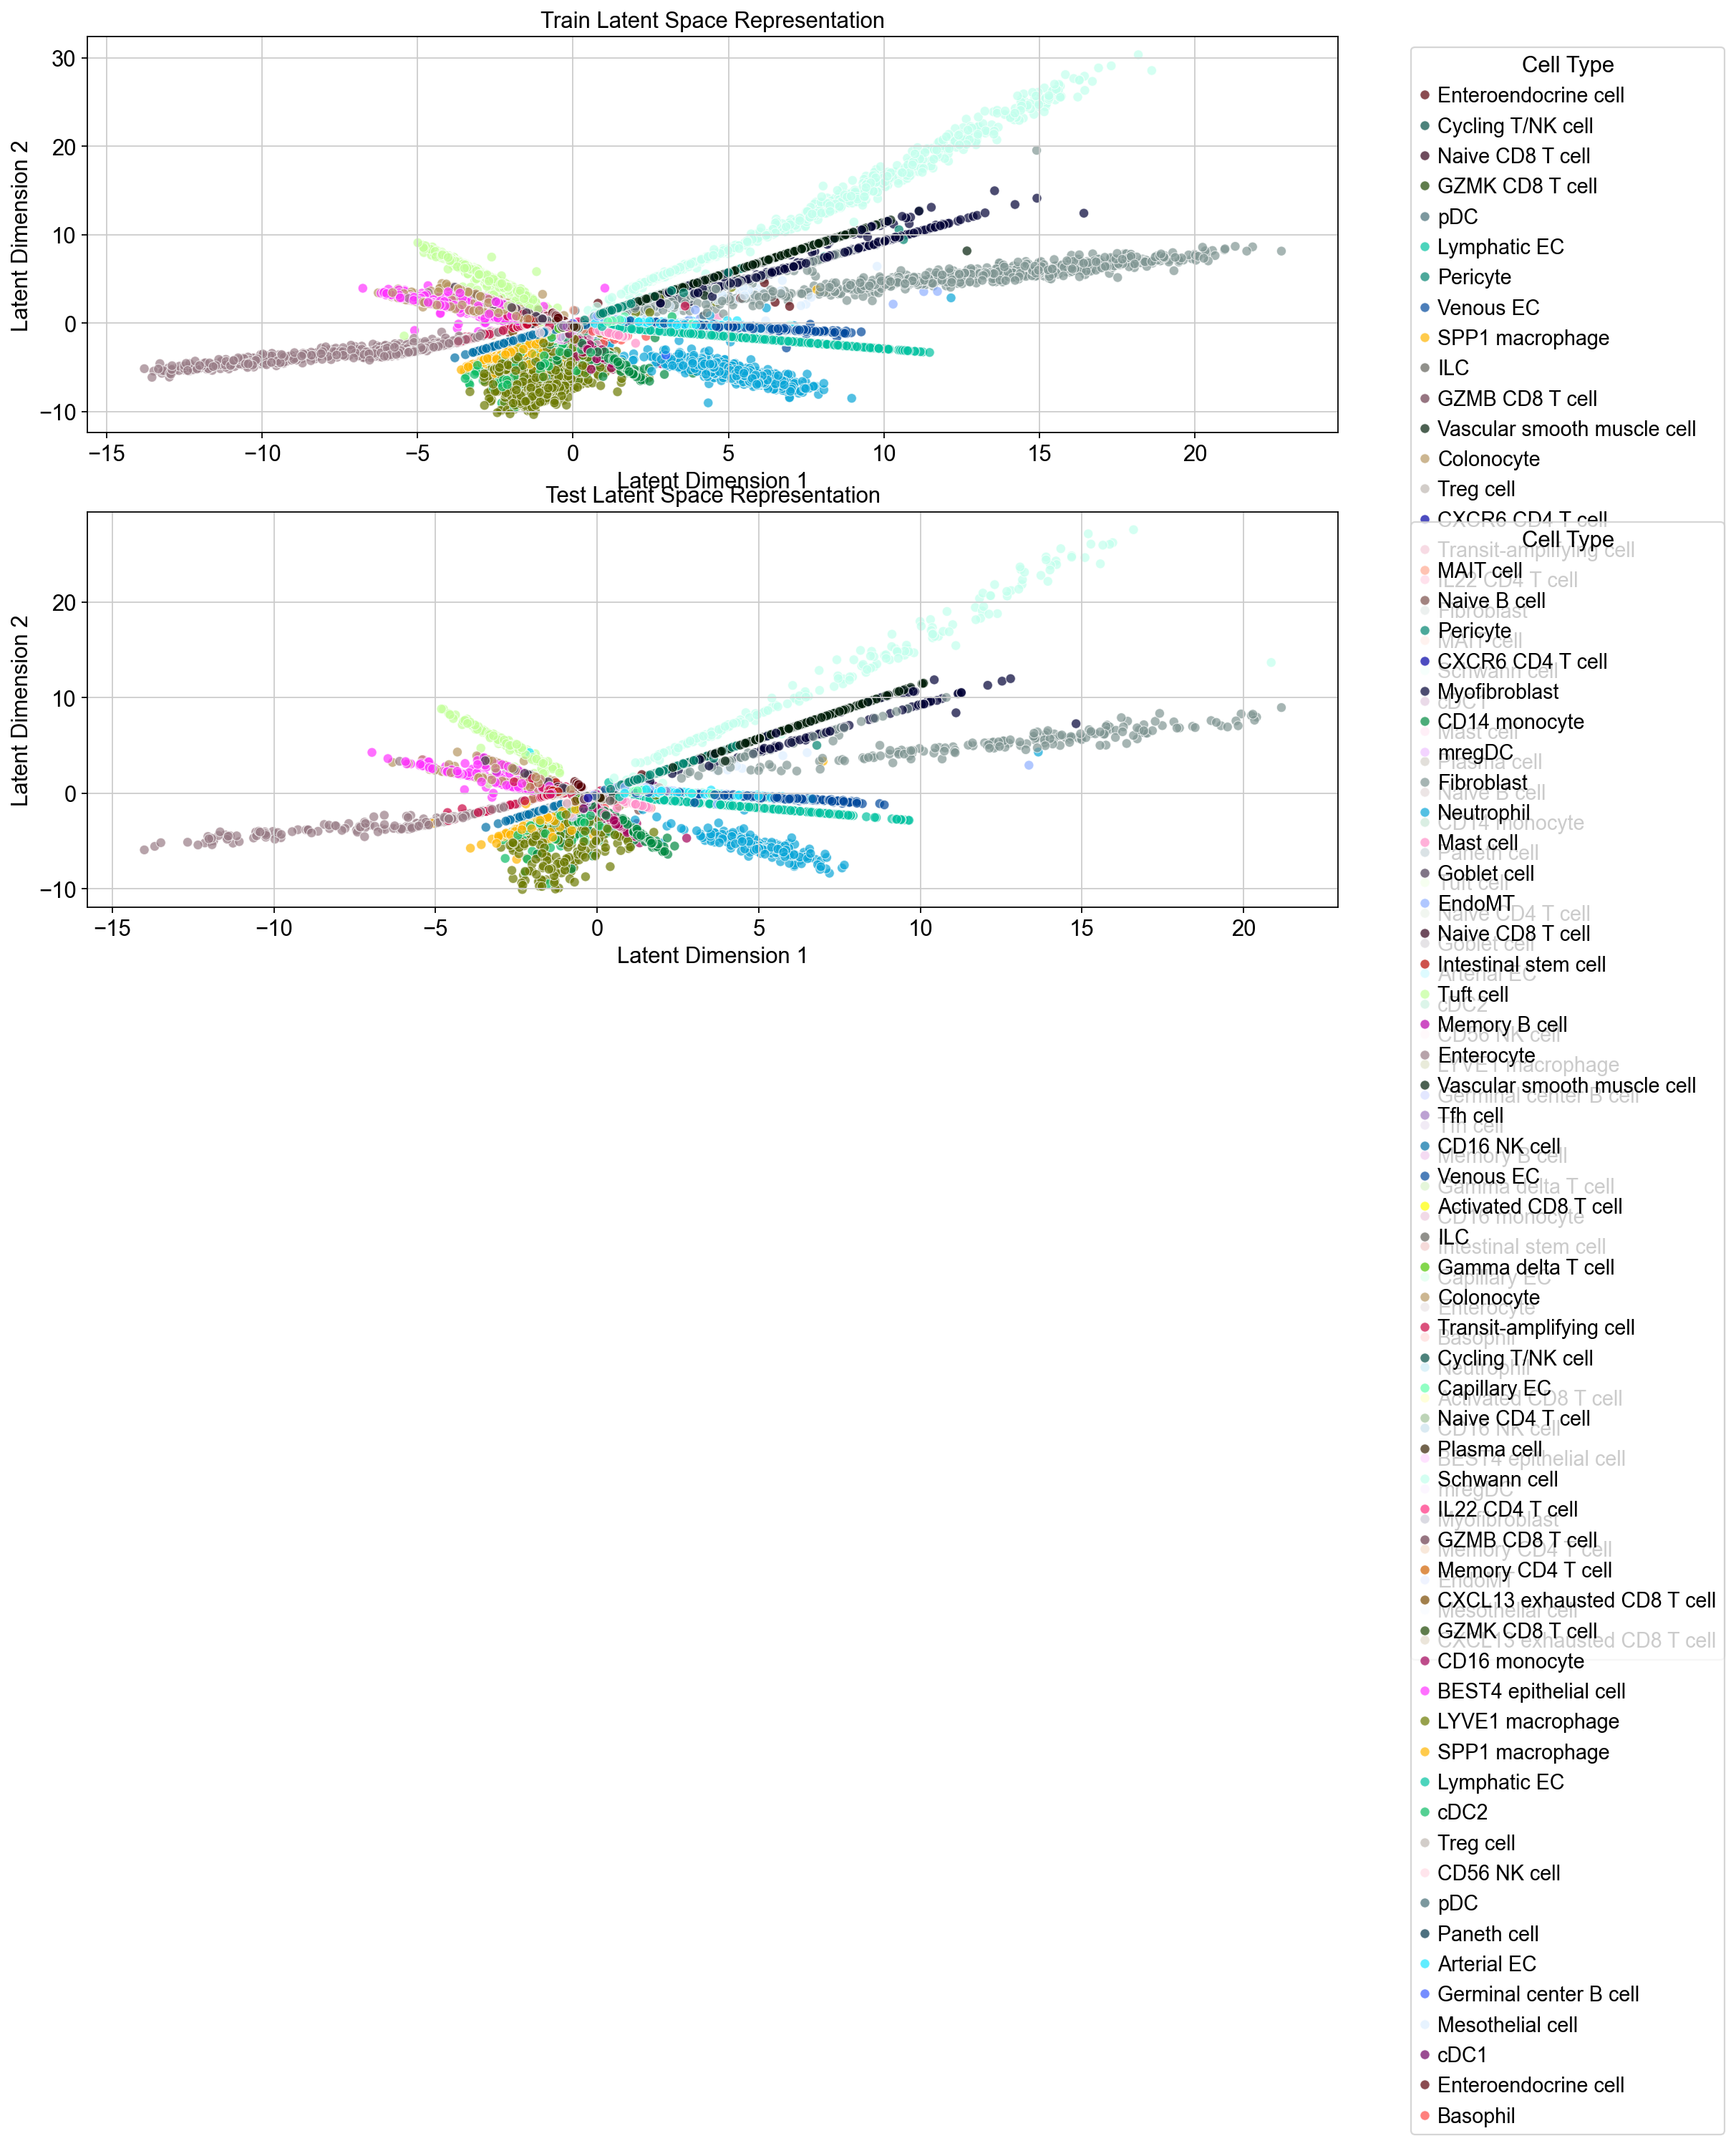

In [48]:
plot_latent_space(model, data_result.train_loader, data_result.test_loader, data_result.label_encoder)